# Configure Phenotype Process Params

This notebook should be used as a test for ensuring correct phenotype image loading and processing before running phenotype processing.
Cells marked with `SET PARAMETERS` contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## SET PARAMETERS

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [2]:
from pathlib import Path

import yaml
import numpy as np
from tifffile import imread
import matplotlib.pyplot as plt
from microfilm import microplot
from microfilm.microplot import Micropanel

from lib.shared.configuration_utils import random_cmap, CONFIG_FILE_HEADER
from lib.shared.file_utils import get_filename
from lib.shared.illumination_correction import apply_ic_field
from lib.shared.segment_cellpose import estimate_diameters
from lib.shared.segment_cellpose import segment_cellpose
from lib.phenotype_process.configuration_utils import annotate_on_phenotyping_data
from lib.phenotype_process.identify_cytoplasm_cellpose import (
    identify_cytoplasm_cellpose,
)
from lib.phenotype_process.extract_phenotype_cp_multichannel import (
    extract_phenotype_cp_multichannel,
)

## SET PARAMETERS

### Parameters for testing SBS processing

- `TEST_WELL`, `TEST_TILE`: Well/tile combination used for configuring parameters in this notebook.

### Feature Extraction

- `FOCI_CHANNEL`: Determines which channel is used for foci detection. This should be set to the index of the channel containing the marker you want to detect foci for.
- `CHANNEL_NAMES`: A list of names for each channel in your phenotyping image. These names will be used in the output data frame to label the features extracted from each channel.

In [3]:
# parameters for testing
TEST_WELL = "A1"
TEST_TILE = 1
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# parameters for feature extraction
FOCI_CHANNEL = 2
CHANNEL_NAMES = ["DAPI", "COXIV", "CENPA", "WGA"]

Loading test image...
Applying illumination correction...
Example corrected image:


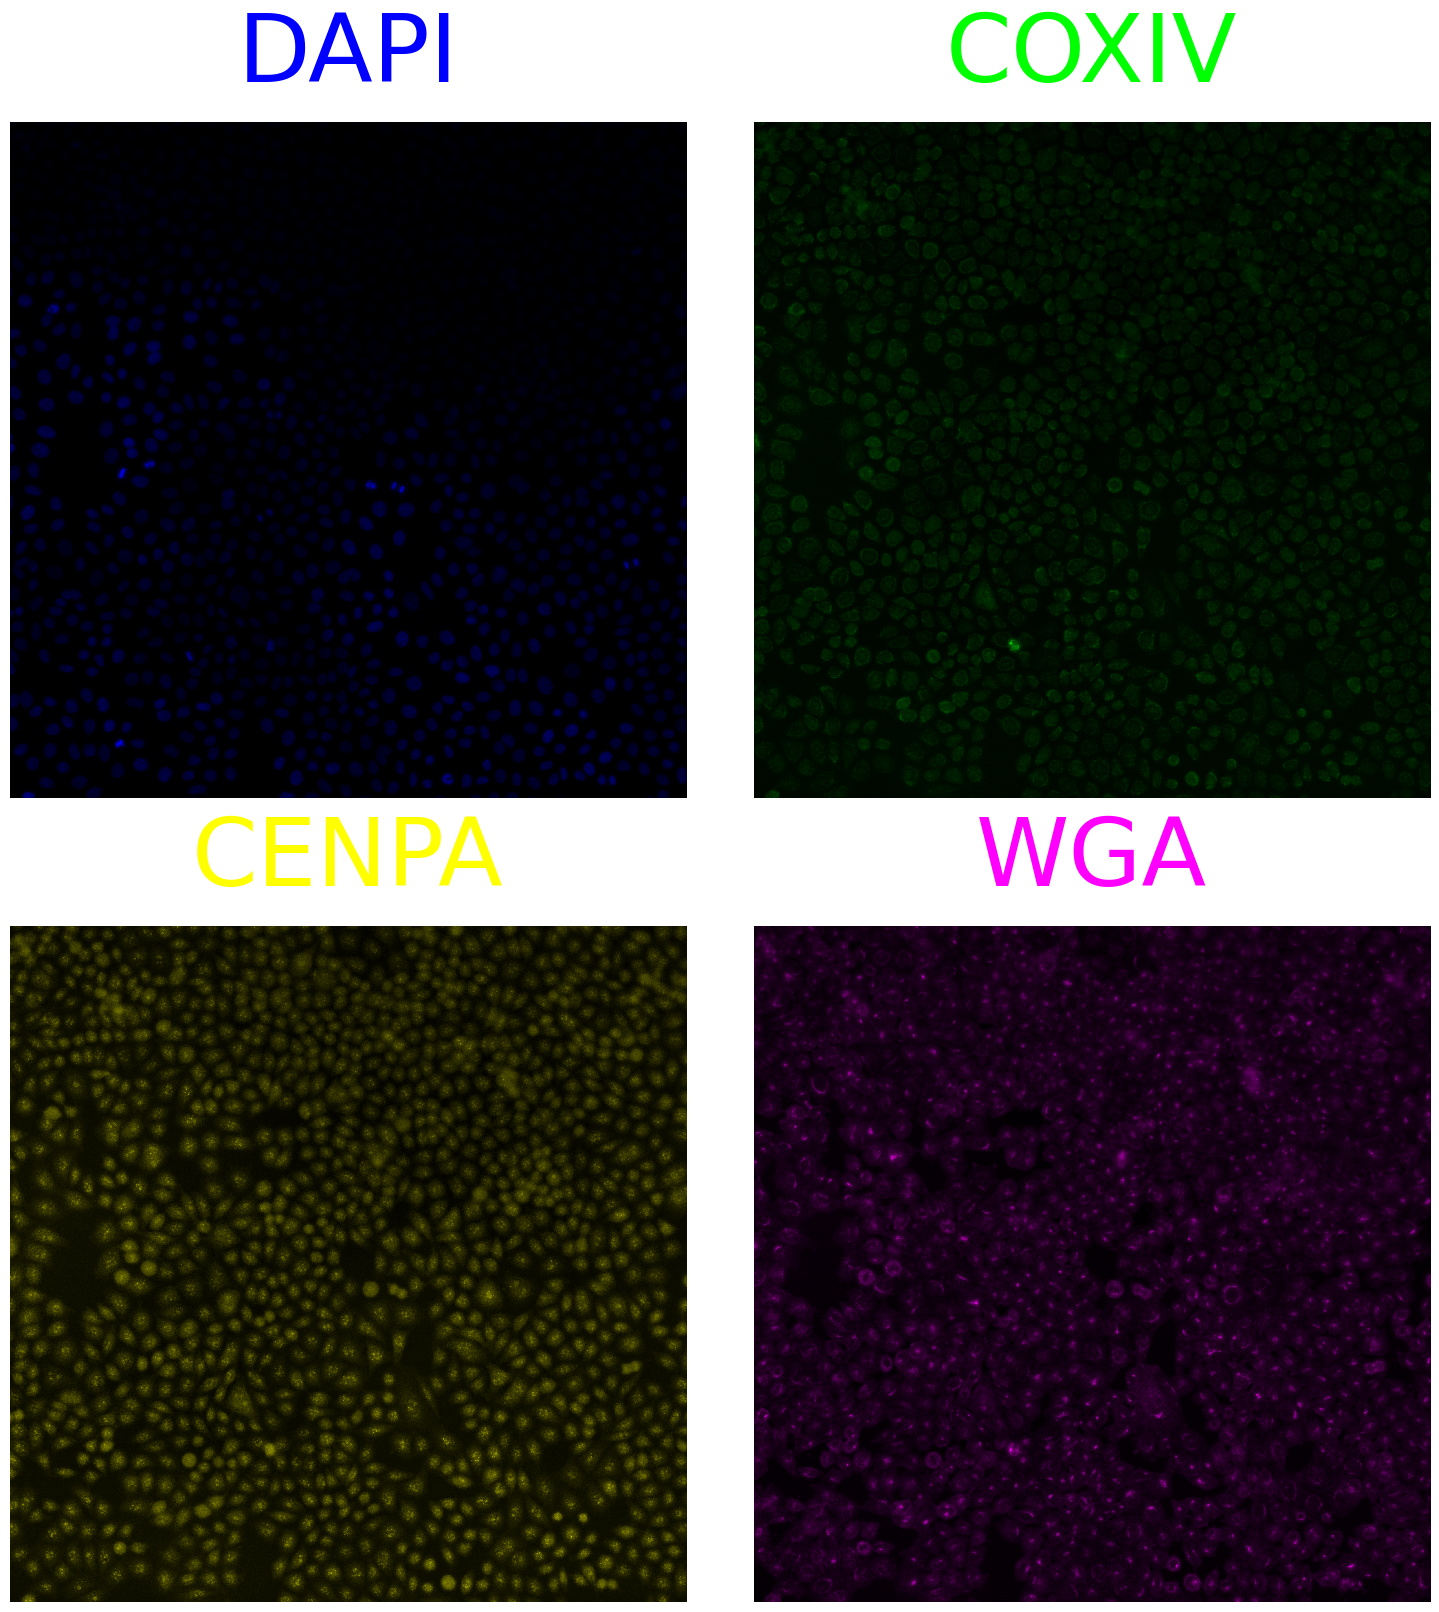

In [4]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# load test image data
print("Loading test image...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
phenotype_test_image_path = str(
    PREPROCESS_FP
    / "images"
    / "phenotype"
    / get_filename(
        {"well": TEST_WELL, "tile": TEST_TILE},
        "image",
        "tiff",
    )
)
phenotype_test_image = imread(phenotype_test_image_path)

print("Applying illumination correction...")
# Read the illumination correction file
ic_field_path = str(
    PREPROCESS_FP
    / "ic_fields"
    / "phenotype"
    / get_filename({"well": TEST_WELL}, "ic_field", "tiff")
)
ic_field = imread(ic_field_path)

# This corresponds to the 'apply_illumination_correction' rule in Snakemake
corrected_image = apply_ic_field(phenotype_test_image, correction=ic_field)

# show corrected
print("Example corrected image:")
ph0_microshow = microplot.Microimage(
    corrected_image[0], cmaps="pure_blue", channel_names=CHANNEL_NAMES[0]
)
ph1_microshow = microplot.Microimage(
    corrected_image[1], cmaps="pure_green", channel_names=CHANNEL_NAMES[1]
)
ph2_microshow = microplot.Microimage(
    corrected_image[2], cmaps="pure_yellow", channel_names=CHANNEL_NAMES[2]
)
ph3_microshow = microplot.Microimage(
    corrected_image[3], cmaps="pure_magenta", channel_names=CHANNEL_NAMES[3]
)
panel = Micropanel(rows=2, cols=2, figscaling=8)
panel.add_element([0, 0], ph0_microshow)
panel.add_element([0, 1], ph1_microshow)
panel.add_element([1, 0], ph2_microshow)
panel.add_element([1, 1], ph3_microshow)
panel.add_channel_label()
plt.show()

## SET PARAMETERS

### Segmentation

- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries.
- `NUCLEI_DIAMETER`: Expected cell nuclei diameter. Used by CellPose during segmentation.
- `CELL_DIAMETER`: Expected cell cytoplasm diameter. Used by CellPose during segmentation.
- `CYTO_MODEL`: CellPose cyto model to use during segmentation.

In [5]:
# Define parameters for CellPose segmentation
CYTO_CHANNEL = "COXIV"
CYTO_MODEL = "cyto3"
FLOW_THRESHOLD = 0.4
CELLPROB_THRESHOLD = 0
GPU = False

# Derive DAPI and CYTO indexes
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

In [6]:
print("Estimating optimal cell and nuclei diameters...")
NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
    corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    cyto_model=CYTO_MODEL,
)

Estimating optimal cell and nuclei diameters...


/lab/barcheese01/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/skimage/util/dtype.py:576: UserWarning: Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8
  return _convert(image, np.uint8, force_copy)


Estimating nuclei diameters...


/lab/barcheese01/miniconda3/envs/brieflow_configuration/lib/python3.11/site-packages/cellpose/resnet_torch.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict =

Estimated nuclear diameter: 41.3 pixels
Estimating cell diameters...
Estimated cell diameter: 52.7 pixels


Segmenting cells...


found 1106 nuclei before removing edges
found 1208 cells before removing edges


removing edges


found 1036 nuclei before reconciling
found 1121 cells before reconciling


reconciling masks with method how=consensus


found 972 nuclei/cells after reconciling


Number of nuclei segmented: 972
Number of cells segmented: 972
Example microplots for DAPI channel and nuclei segmentation:


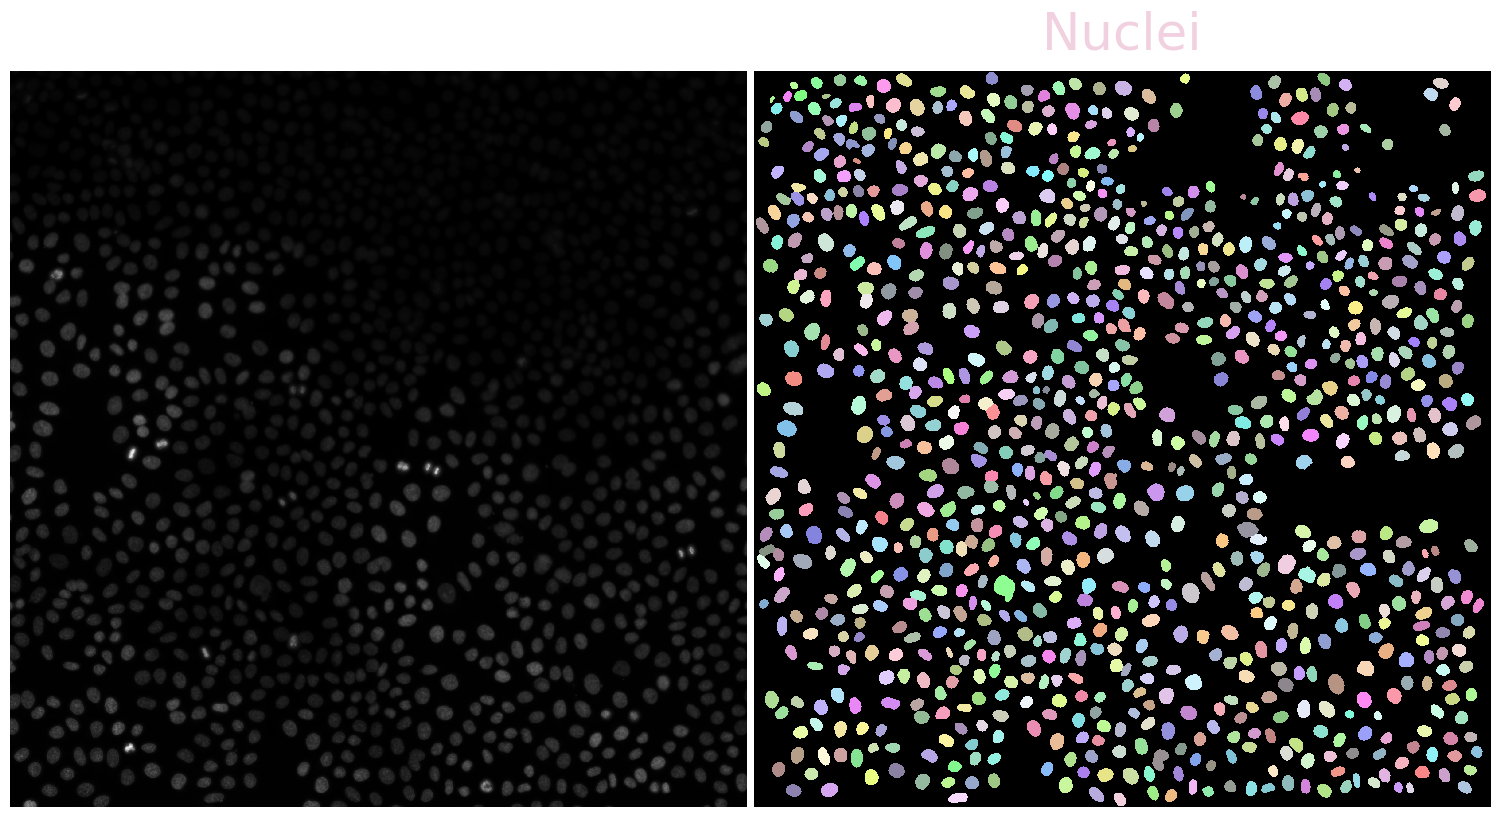

Example microplots for merged channels and cells segmentation:


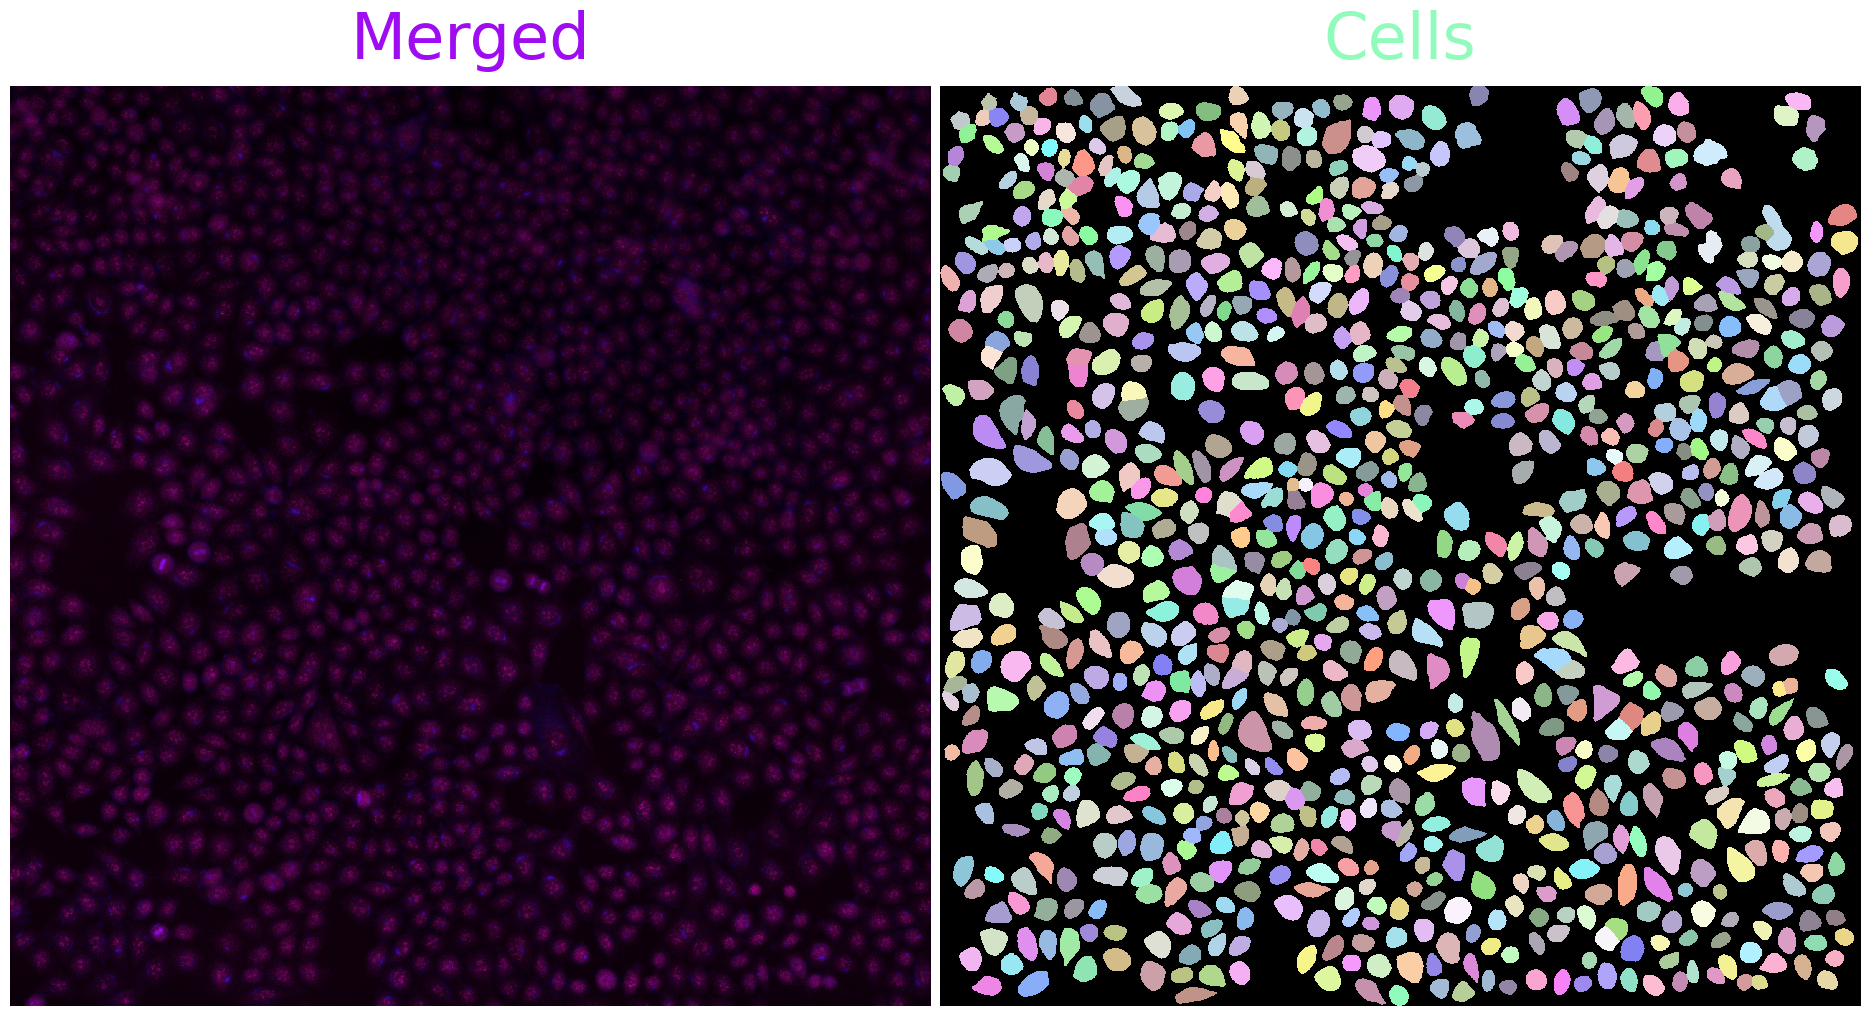

Example microplot for phenotype data annotated with segmenation:


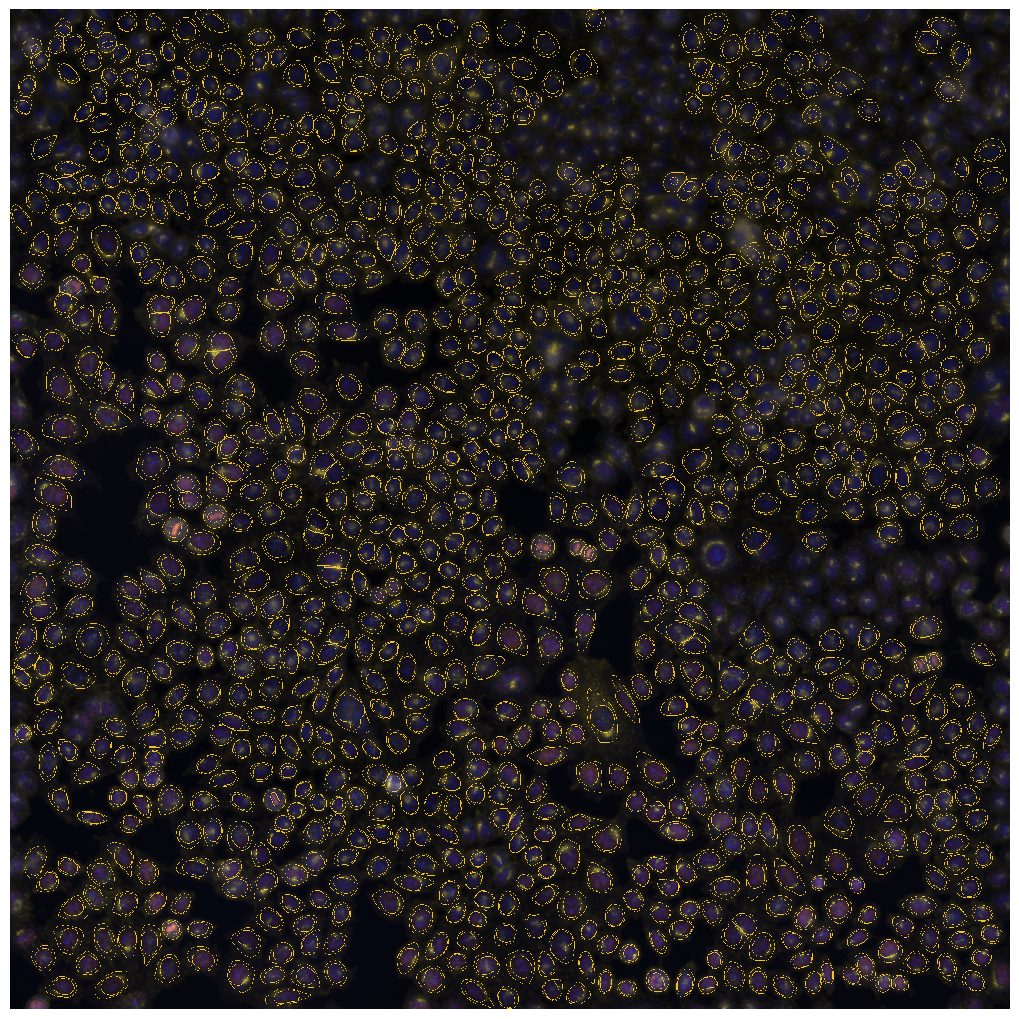

Example microplots for cytoplasms relative to nuclei:
Number of cytoplasms identified: 972


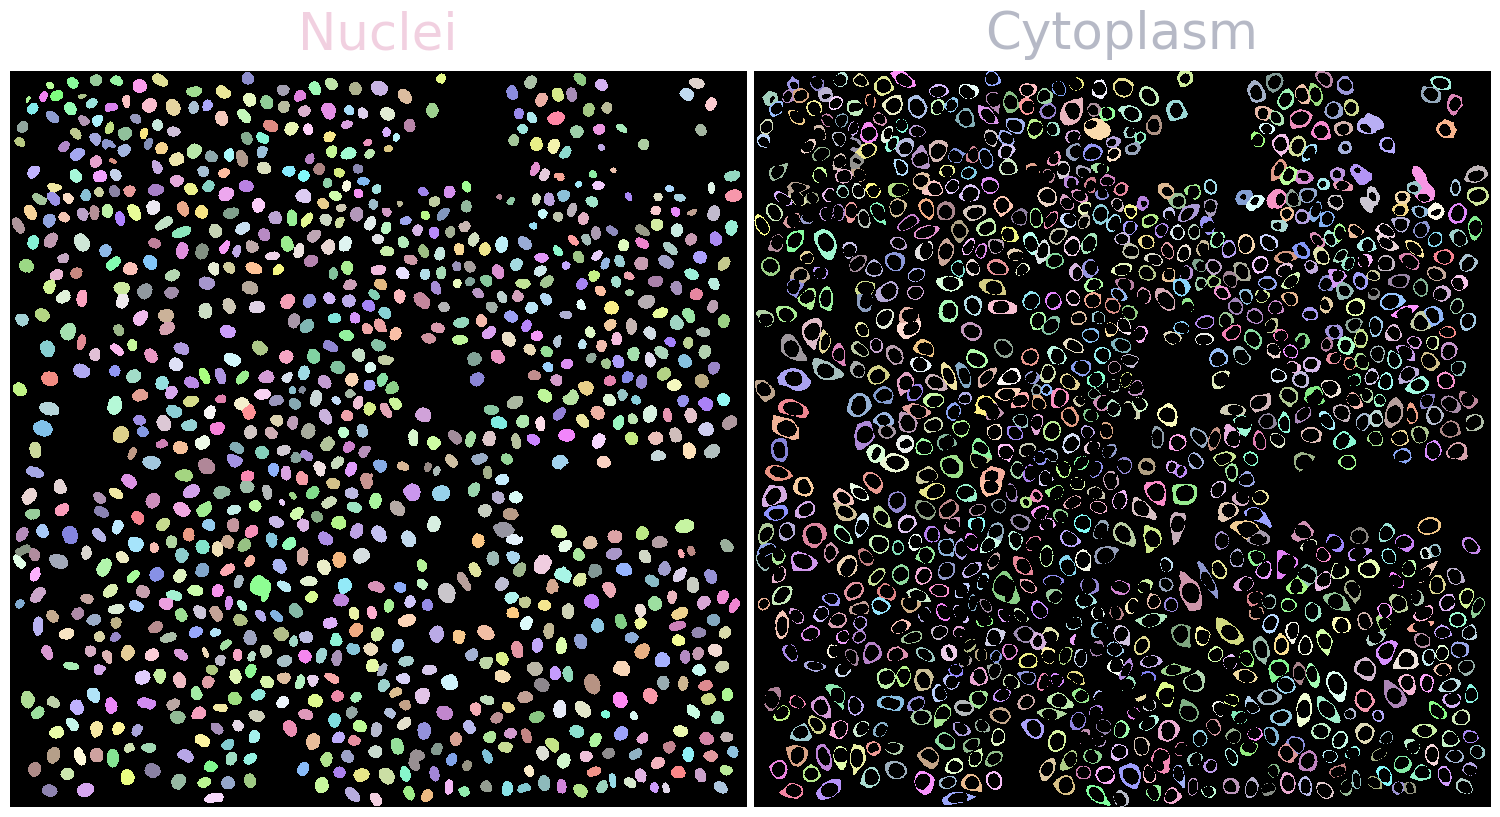

In [7]:
print("Segmenting cells...")
nuclei, cells = segment_cellpose(
    data=corrected_image,
    dapi_index=DAPI_INDEX,
    cyto_index=CYTO_INDEX,
    nuclei_diameter=NUCLEI_DIAMETER,
    cell_diameter=CELL_DIAMETER,
    cellpose_kwargs=dict(
        flow_threshold=FLOW_THRESHOLD,
        cellprob_threshold=CELLPROB_THRESHOLD,
    ),
    cyto_model=CYTO_MODEL,
    gpu=GPU,
)

print("Example microplots for DAPI channel and nuclei segmentation:")
dapi_microshow = microplot.Microimage(corrected_image[DAPI_INDEX], channel_names="DAPI")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_microshow = microplot.Microimage(
    nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], dapi_microshow)
panel.add_element([0, 1], nuclei_microshow)
panel.add_channel_label()
plt.show()

print("Example microplots for merged channels and cells segmentation:")
all_microshow = microplot.Microimage(corrected_image, channel_names="Merged")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_microshow = microplot.Microimage(cells, cmaps=cells_cmap, channel_names="Cells")
panel = Micropanel(rows=1, cols=2, figscaling=10)
panel.add_element([0, 0], all_microshow)
panel.add_element([0, 1], cells_microshow)
panel.add_channel_label()
plt.show()

print("Example microplot for phenotype data annotated with segmenation:")
annotated_data = annotate_on_phenotyping_data(corrected_image, nuclei, cells)
annotated_microshow = microplot.Microimage(annotated_data, channel_names="Merged")
panel = Micropanel(rows=1, cols=1, figscaling=10)
panel.add_element([0, 0], annotated_microshow)
plt.show()

print("Example microplots for cytoplasms relative to nuclei:")
cytoplasms = identify_cytoplasm_cellpose(nuclei, cells)
cytoplasm_cmap = random_cmap(num_colors=len(np.unique(cytoplasms)))
cytoplasm_microshow = microplot.Microimage(
    cytoplasms, cmaps=cytoplasm_cmap, channel_names="Cytoplasm"
)
panel = Micropanel(rows=1, cols=2, figscaling=8)
panel.add_element([0, 0], nuclei_microshow)
panel.add_element([0, 1], cytoplasm_microshow)
panel.add_channel_label()
plt.show()

In [8]:
print("Extracting phenotype features:")
phenotype_cp = extract_phenotype_cp_multichannel(
    corrected_image,
    nuclei=nuclei,
    cells=cells,
    wildcards=WILDCARDS,
    cytoplasms=cytoplasms,
    foci_channel=FOCI_CHANNEL,
    channel_names=CHANNEL_NAMES,
)

phenotype_cp

Extracting phenotype features:


label  nucleus_DAPI_int  nucleus_COXIV_int  nucleus_CENPA_int  \
0        1            808978             328333             370427   
1        2            620225             243945             322268   
2        3            620848             276745             365643   
3        4            393327             195619             247072   
4        5            545215             238846             318991   
..     ...               ...                ...                ...   
967    968           3755999             380829             460733   
968    969           3787553             380281             497013   
969    970           3489749             320904             450649   
970    971           4777834             409689             583634   
971    972           2819775             325593             443383   

     nucleus_WGA_int  nucleus_DAPI_mean  nucleus_COXIV_mean  \
0            2670108         619.906513          251.596169   
1            2081598         484.929633          190.731040   
2            2989557         387.303805          172.641921   
3            1810456         476.182809          236.826877   
4            2433969         432.024564          189.259905   
..               ...                ...                 ...   
967          3371701        3860.225077          391.396711   
968          3492255        2170.517479          217.926074   
969          3247065        2747.833858          252.680315   
970          4304867        2847.338498          244.153159   
971          3329051        2071.840558          239.230713   

     nucleus_CENPA_mean  nucleus_WGA_mean  nucleus_DAPI_std  ...  \
0            283.852107       2046.059770        122.094080  ...   
1            251.968726       1627.519937         78.563768  ...   
2            228.099189       1864.976294         67.375101  ...   
3            299.118644       2191.835351         45.821971  ...   
4            252.766244       1928.660063         81.754194  ...   
..                  ...               ...               ...  ...   
967          473.517986       3465.263104       1117.374508  ...   
968          284.821203       2001.292264        470.687050  ...   
969          354.841732       2556.744094        454.390903  ...   
970          347.815256       2565.474970        581.877711  ...   
971          325.777370       2446.033064        337.852313  ...   

     cell_number_neighbors_1  cell_percent_touching_1  \
0                          0                      0.0   
1                          0                      0.0   
2                          0                      0.0   
3                          0                      0.0   
4                          0                      0.0   
..                       ...                      ...   
967                        0                      0.0   
968                        0                      0.0   
969                        0                      0.0   
970                        0                      0.0   
971                        0                      0.0   

     cell_first_neighbor_distance  cell_second_neighbor_distance  \
0                       72.940852                      87.462855   
1                       58.518474                      71.470725   
2                       68.387348                      90.893276   
3                      109.135381                     131.531322   
4                       64.482337                      70.303943   
..                            ...                            ...   
967                     54.812584                      75.119223   
968                     70.352255                      78.222015   
969                     60.520662                      70.535353   
970                     59.850860                      68.867360   
971                     78.222015                      81.448650   

     cell_angle_between_neighbors  cytoplasm_number_neighbors_1  \
0                    

In [9]:
# Remove channel names from feature names
def remove_channel_name(feature, channels):
    for channel in channels:
        feature = feature.replace(f"_{channel}", "")
    return feature

# Remove label, well, tile and isolate remaining feature names
filtered_features = [
    feature
    for feature in phenotype_cp.columns.tolist()
    if feature not in ["label", "well", "tile"]
]

# Apply the function to remove channel names
feature_types = [
    remove_channel_name(feature, CHANNEL_NAMES) for feature in filtered_features
]

# Get unique feature types
unique_feature_types = sorted(set(feature_types))

print("Unique feature types:")
unique_feature_types

Unique feature types:


['cell_K',
 'cell_angle_between_neighbors',
 'cell_area',
 'cell_bounds_0',
 'cell_bounds_1',
 'cell_bounds_2',
 'cell_bounds_3',
 'cell_center_mass_c',
 'cell_center_mass_r',
 'cell_centroid_c',
 'cell_centroid_r',
 'cell_compactness',
 'cell_convex_area',
 'cell_correlation',
 'cell_eccentricity',
 'cell_euler_number',
 'cell_extent',
 'cell_first_neighbor_distance',
 'cell_foci_area',
 'cell_foci_count',
 'cell_form_factor',
 'cell_frac_at_d_0',
 'cell_frac_at_d_1',
 'cell_frac_at_d_2',
 'cell_frac_at_d_3',
 'cell_haralick_5_0',
 'cell_haralick_5_1',
 'cell_haralick_5_10',
 'cell_haralick_5_11',
 'cell_haralick_5_12',
 'cell_haralick_5_2',
 'cell_haralick_5_3',
 'cell_haralick_5_4',
 'cell_haralick_5_5',
 'cell_haralick_5_6',
 'cell_haralick_5_7',
 'cell_haralick_5_8',
 'cell_haralick_5_9',
 'cell_hu_moments_0',
 'cell_hu_moments_1',
 'cell_hu_moments_2',
 'cell_hu_moments_3',
 'cell_hu_moments_4',
 'cell_hu_moments_5',
 'cell_hu_moments_6',
 'cell_i',
 'cell_int',
 'cell_int_edge',

## Add phenotype process parameters to config file

In [ ]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Add phenotype_process section
config["phenotype_process"] = {
    "foci_channel": FOCI_CHANNEL,
    "channel_names": CHANNEL_NAMES,
    "dapi_index": DAPI_INDEX,
    "cyto_index": CYTO_INDEX,
    "nuclei_diameter": NUCLEI_DIAMETER,
    "cell_diameter": CELL_DIAMETER,
    "flow_threshold": FLOW_THRESHOLD,
    "cellprob_threshold": CELLPROB_THRESHOLD,
    "cyto_model": CYTO_MODEL,
    "gpu": GPU,
    "mode": "segment_phenotype_paramsearch",
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False)